# Asignment 2


In [2]:
import networkx as nx
import numpy as np 
import pandas as pd
import json
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt 
import os
import pickle
import copy 
import random
import seaborn as sns 
from scipy.stats import pearsonr,ttest_1samp

### Part 1
Exercise 1: Mixing Patterns and Assortativity.

Overview of the tasks: 
* For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes.
* Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled. Compute the measure above for this randomized graph.
* Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?
* Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain? (Hint: See this paper, eq (2)). Important: here I do not want you to use the NetworkX implementation, but rather to implement your own version of the measure.
* Is the graph assortative with respect to the degree? (e.g. do high-degree scientists tend to link to other high-degree scientists, and low-degree scientists to other low-degree scientists?). Provide an interpretation of your answer.
* Optional: Estimate the gender of each author from their name, using the World Gender Name Dictionary. Repeat the analysis above to study the assortativity of the network by gender rather than by field. What do you observe? 

Start out by reading in the graph from week 4, from the json file.

In [3]:
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [4]:
#Only if you use colab
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [5]:
G = read_json_file('/content/gdrive/MyDrive/Computational Social Science/graph.json')
print(G)

Graph with 4640 nodes and 9376 edges


Exctracting the giant connected component from the graph. 

In [6]:
s = max(nx.connected_components(G), key=len)
G = G.subgraph(s)

### Calculating the fraction of edges to same subfield
For this exercise the fractions of edges connecting to nodes with the same top-field is calculated. This is done by iterating through the nodes in the graph, then for each of the nodes a value is stored in a dictionary, such that the mean value of the fractions can be computed later on. 

In [7]:
def calc_fraction(G): 
  fractions = {}
  for id in G.nodes:
    field = G.nodes[id]['field']
    same_top_field = 0
    n_neighbours = 0
    for neighbour_id in G.neighbors(id):
      neighbour = G.nodes[neighbour_id]
      if neighbour['field'] == field:
        same_top_field += 1
    
      n_neighbours += 1
    fractions[id] = same_top_field/n_neighbours if len(list(G.neighbors(id))) != 0 else 0

  return fractions

Compute the average of the fractions, from the dictionary which is created in the function defined above. 

In [8]:
fractions = calc_fraction(G)
n = sum(fractions.values())/len(fractions.values())
t = f'Average fraction of nodes connecting to another with the same field: \n{n}'
print(t)

Average fraction of nodes connecting to another with the same field: 
0.5136100357093106


### Random shuffeling fields
Now we will random shuffle the fields between the nodes. This is done, by simply creating a list of the fields in the graph, and then by random selecting a field for a given node. For this exercise it is important that the probabillity of having a certain field is still preserved, especilly because the top-fields had to be randomly shuffled between nodes. This is solved by randomly selecting a field, from the entire fields list **without** replacement.  

In [9]:
# Get the list of fields in the original graph
np.random.seed(0)
def random_shuffle_fields(G):
  fields = list(nx.get_node_attributes(G, 'field').values())
  #fields = fields[1:] # First is nan for some reason
  measure_shuffled = []

  # Create a new graph with the same nodes and edges as the original graph,
  # but with the fields shuffled
  G_shuffled = copy.deepcopy(G)
  for node in G_shuffled.nodes:
      #rand_idx = random.randint(0,len(fields)-1)
      G_shuffled.nodes[node]['field'] = np.random.choice(fields,replace=False)

  # Compute the measure for the shuffled graph
  fractions = calc_fraction(G_shuffled)
  measure_shuffled = sum(fractions.values())/len(fractions.values())

  #print(f"The measure for the shuffled graph is: {measure_shuffled}")
  return measure_shuffled

Now the function can be called on the graph ```G```

In [10]:
random_shuffle_fields(G)

0.3564545460445377

So this is quite a lot lower than what that what was seen before, hower since the number is based on random selection the function can be called multiple times to give a more robust estimate. 

### Repeating the same thing 150 times
Now the function can be called 150 times, since it gives a more robust estimate, it was chosen to run the random shuffle, a bit more than the minimum requirement. 

In [12]:
meassures = []
for i in range(150):
  meassures.append(random_shuffle_fields(G))

Now the distribution will be plottet, and what can be seen from the plot is that it looks rather normal distributed, but with really low values, and it definitly looks like it is significantly different than the 0.3 that was observed when computing for the original graph. 

Text(0.5, 0, 'Fraction Meassures')

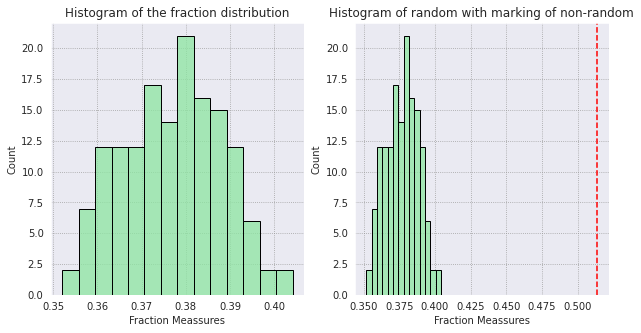

In [22]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig,ax = plt.subplots(1,2,figsize = (10,5))
# Hist
sns.histplot(meassures, bins = 14, ax = ax[0],edgecolor = "black",color = '#8de5a1')
ax[0].set_title("Histogram of the fraction distribution")
ax[0].set_xlabel("Fraction Meassures")
#Comparison 
sns.histplot(meassures, bins = 14, ax = ax[1],edgecolor = "black",color = '#8de5a1')
ax[1].axvline(n, color="r", linestyle="--")
ax[1].set_title("Histogram of random with marking of non-random")
ax[1].set_xlabel("Fraction Meassures")

As can be seen the two values are quite far appart, and thus a conclusion would be that it is not coencidental that the nodes with the same topfield, are often connected together. However to be a bit more rigourus in the approach to testing this, one can compute a 1samp ttest, in which it is tested if the mean value computed for the real graph is the mean value for the random graph. This wil then assume that the true mean, is the one from the css-graph. Furthermore since it is a distribution of means, the central limit theorem applies, and a normal distribution can be assumed.  

In [14]:
ttest_1samp(meassures,popmean = n)

TtestResult(statistic=-150.09155320658988, pvalue=1.6905597981211524e-164, df=149)

So from these results the H0 of equal means, is rejected with $\alpha = 0.05$. Confirming the intution from the plot, that the connection between authors with the same fields, are significantly different than if their fields had been randomly assigned. 

#### Computing the assortativity coefficient 
In order to implement the coefficient the formula from *(Newman,2003)*: 

$$r=\frac{\sum_i e_{i i}-\sum_i a_i b_i}{1-\sum_i a_i b_i}=\frac{\operatorname{Tr}\mathbf{e}-\left\|\mathbf{e}^2\right\|}{1-\left\|\mathbf{e}^2\right\|}$$

Where Tr denotes the trace of the matrix. 
First the e matrix will be computet which is the fraction how many times a node with one field connects with another. Do note that some of the fields are ```nan``` values, however it was discussed that these nodes could still be usfull for interpreting how the network connects. 

In the code below, the counting matrix has been implemented for both the categorical and degree, since the degree will be used later, this was done in order to collect the very similar functions, and hopefully make it more readable.

In [24]:
def e_matrix(G,att):
  #Get the fields
  fields = list(set(nx.get_node_attributes(G, att).values()))

  #Smart index trick
  category_indices = {fields: i for i, fields in enumerate(fields)}

  # Loop Through and and increment the correct indicies
  N = len(fields)
  e = np.zeros((N, N))
  for u, v in G.edges():
      i = category_indices[G.nodes[u][att]]
      j = category_indices[G.nodes[v][att]]
      e[i, j] += 0.5
      e[j, i] += 0.5

  norm_coef = G.number_of_edges() # To do some standardization of the matrix 
  e = e/norm_coef
  return e

#calcutlate the coefficient for the the graph. 
def get_assortativity_coefficient(G,att,cat = True):
  e = e_matrix(G,att) # Get matrix
  return (np.trace(e) - np.sum(np.sum(e, axis=0)**2))/(1-np.sum(np.sum(e, axis=0)**2))

In [25]:
get_assortativity_coefficient(G,'field')

0.14471860156236596

Test the implementation, with the nx implementation. Quite close to the answer so, so the implementation above should be correct. 

In [26]:
nx.attribute_assortativity_coefficient(G,'field')

0.1447186015623659

From this metric, it can be concluded that the graph is moderatly assortative with respect to the topfield, since it is slightly positive. This in terms mean that authors with the same top-field do tend to connect to eachother more than they would randomly, however not in a very strong manner. 

### Assortivity with respect to degree

For this part the assortivity coeficient will be calculated with respect to the degree of the nodes, and it will be discussed weather highly connected authors tend to connect with other highly connected authors. According to *(Newman,2003)* this would be equivalent to finding the pearson correlation between the degrees of the edges. This is also the approach that was followed in this exercise. First the x,y coordinates are found, such that x has the degree of on node and y the degree of a connecting node. However the datapoint (y,x) is also added, since the graph is undirected. This way will also allow for plotting the points, which will then also reveal if the correlation might be non-linear.

In [30]:
def get_xy_vals(G):
  """ 
  This function will create a datapoint for each pair in the graph
  with their respective degrees as value.
  G: Networkx graph
  """
  x,y = [],[]
  for edge in G.edges():
    X_deg = G.degree(edge[0])
    Y_deg = G.degree(edge[1])
    x.append(X_deg)
    y.append(Y_deg)
    y.append(X_deg)
    x.append(Y_deg)
    
  return x,y 
x,y = get_xy_vals(G)

Test the results with the pearson correlation calculated by using the ```scipy.stats``` module, and check if the results are consistent with the networkx implementation. 

In [34]:
pearsonr(x,y)

PearsonRResult(statistic=-0.011556789318338659, pvalue=0.13627090173424145)

Testing if the implementation is correct: 

In [35]:
nx.degree_assortativity_coefficient(G)

-0.011556789318338603

So the implementation is consistent with the networkx implementation. From this number however, it can be concluded that the graph is not really assortative with respect to degree, however it also slightly negativly assortative, however so vagualy that it is more up to chance if a node connects to a very well connected node or a weakly connected node. 

Now the datapoints can be plotted, in the x,y plane, in order to give a better insight into how they are connected. 

<ipython-input-41-dbe1dad5d453>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = x,y = y,palette="deep",marker=".", color = 'darkred')


Text(0, 0.5, 'Degree')

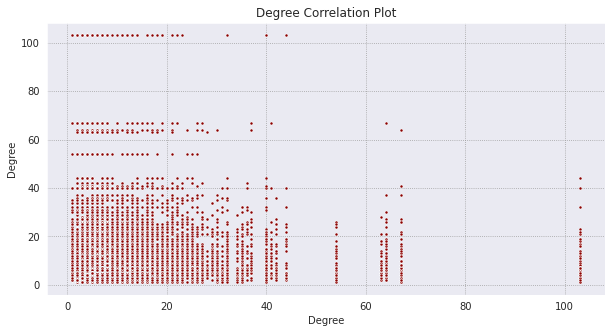

In [41]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax,fig = plt.subplots(1,figsize = (10,5))
sns.scatterplot(x = x,y = y,palette="deep",marker=".", color = 'darkred')
plt.title("Degree Correlation Plot")
plt.xlabel("Degree")
plt.ylabel("Degree")

From these results two things are are clear first of the pearson correlation did not prove to be significantly different from zero, which also means that the graph does not seem to be assortative with respect to the degree of the nodes. From the plot however it is also quite apparent that no real correlation between degrees of nodes exists. One interesting thing the plot reveals however, is the fact that most of the degrees are in the lower range, while only a few is having a lot of outgoing degrees. 

### Estimating gender of each author from their name

For this optional task, the gender can be found using the world gender name dictionary, which can be loaded into the nodebook using the gender_guesser library, which is build on a data-base quite similar to the World Gender Name Dictionary, so in order to avoid downloading the entire file, this library is used. It only works on the first name, so for this exercise it will be assumed that the first "word" in the name is their first name.  

In [42]:
!pip install gender_guesser # Install the package 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 KB 11.8 MB/s eta 0:00:00


In [43]:
import gender_guesser.detector as gender # Import the detector

First iterate the graph, get the gender then create a new field in the graph called "Gender". One thing to take into account is the fact that the function ```get_gener```will return unknown if the name does not exist in the database. 

In [44]:
d = gender.Detector()
# Now loop through 
for node in G.nodes():
  auth_name = G.nodes[node]['name'].split(' ')[0]
  g = d.get_gender(auth_name)
  G.nodes[node]['Gender'] = g

Get the assortivity coeficient with respect to the gender. 

In [45]:
get_assortativity_coefficient(G,'Gender')

0.08357252652313839

So this would suggest that most of the computational social scientists in the graph does not really connect to any kind of gender, and it is mostly random who they connect with *(with respect to gender of course)*. All in all the network of computational social scientists does not seem to have any bias, regarding the gender of who they work with. 

## References
Newman, M. E. (2003). Mixing patterns in networks. Physical review E, 67(2), 026126.